In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="darkgrid") 
sns.set_context("notebook", font_scale=1.1)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

CHECKPOINT_DIR = Path("./artifacts")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = CHECKPOINT_DIR / "best_resnet_soil.pth"

## 1. EDA — Image dataset

In [3]:
from pathlib import Path
import glob

# Include both original and augmented image datasets
IMAGE_ROOTS = [
    Path("./data/soil_images/Orignal-Dataset"),
    Path("./data/soil_images/CyAUG-Dataset"),
]

image_paths = []
for root in IMAGE_ROOTS:
    image_paths.extend(root.glob("*/*"))

if len(image_paths) == 0:
    raise FileNotFoundError(f"No images found under {IMAGE_ROOTS} – check paths or download.")

img_records = []
for p in image_paths:
    label = p.parent.name
    img_records.append((str(p), label, p.parent.parent.name))  # filepath, label, source

img_df = pd.DataFrame(img_records, columns=["filepath", "label", "source"])
print("Image dataset shape:", img_df.shape)
print("Source split:\n", img_df["source"].value_counts())
print("Label counts:\n", img_df["label"].value_counts())
print("Sample rows:")
display(img_df.sample(5, random_state=0))

Image dataset shape: (6286, 3)
Source split:
 source
CyAUG-Dataset      5097
Orignal-Dataset    1189
Name: count, dtype: int64
Label counts:
 label
Yellow_Soil      1470
Black_Soil       1428
Red_Soil         1235
Alluvial_Soil     745
Arid_Soil         568
Laterite_Soil     438
Mountain_Soil     402
Name: count, dtype: int64
Sample rows:


,filepath,label,source
4230,data\soil_images\CyAUG-Dataset\Red_Soil\r (409...,Red_Soil,CyAUG-Dataset
4292,data\soil_images\CyAUG-Dataset\Red_Soil\r (465...,Red_Soil,CyAUG-Dataset
3362,data\soil_images\CyAUG-Dataset\Laterite_Soil\1...,Laterite_Soil,CyAUG-Dataset
2434,data\soil_images\CyAUG-Dataset\Black_Soil\b (1...,Black_Soil,CyAUG-Dataset
5883,data\soil_images\CyAUG-Dataset\Yellow_Soil\y (...,Yellow_Soil,CyAUG-Dataset


## 2. EDA — Tabular datasets

In [20]:
d1 = pd.read_csv('./data/tabular/d1.csv')
d2 = pd.read_csv('./data/tabular/d2.csv')
d3 = pd.read_csv('./data/tabular/d3.csv')

datasets = {'d1': d1, 'd2': d2, 'd3': d3}

In [21]:
# 1. Clean D3 Soil Colors
def clean_soil_color(color):
    if pd.isna(color):
        return "unknown"
    color = str(color).lower().strip()
    
    # Fix specific typos found in the dataset
    color = color.replace("redish", "reddish")
    color = color.replace("broown", "brown")
    color = color.replace("grey", "gray")
    
    # Map variations to standard colors
    if "yellow" in color:
        return "yellowish brown"
    
    # Handle "dark brown" and "very dark brown" -> "dark brown"
    if "dark brown" in color:
        return "dark brown"
        
    # Handle reddish brown variations
    if "red" in color:
        if "brown" in color:
            return "reddish brown"
        elif "gray" in color:
            return "reddish gray"
        return "red"
        
    # Handle grayish brown variations
    if "gray" in color:
        if "brown" in color:
            return "grayish brown"
        return "gray"
        
    if "black" in color:
        return "black"
        
    if "brown" in color:
        return "brown"
    
    return "other"

if 'Soilcolor' in d3.columns:
    d3['Soilcolor'] = d3['Soilcolor'].apply(clean_soil_color)
    print("Cleaned Soilcolor unique values:", sorted(d3['Soilcolor'].unique()))

# 2. Drop useless columns from D3
cols_to_drop = [
    "QV2M-W", "QV2M-Sp", "QV2M-Su", "QV2M-Au",
    "T2M_MAX-W", "T2M_MAX-Sp", "T2M_MAX-Su", "T2M_MAX-Au",
    "T2M_MIN-W", "T2M_MIN-Sp", "T2M_MIN-Su", "T2M_MIN-Au",
    "PRECTOTCORR-W", "PRECTOTCORR-Sp", "PRECTOTCORR-Su", "PRECTOTCORR-Au",
    "WD10M", "GWETTOP", "CLOUD_AMT", "WS2M_RANGE"
]
# Only drop if they exist
existing_cols_to_drop = [c for c in cols_to_drop if c in d3.columns]
if existing_cols_to_drop:
    d3 = d3.drop(columns=existing_cols_to_drop)
    print(f"Dropped {len(existing_cols_to_drop)} columns from d3: {existing_cols_to_drop}")
else:
    print("No columns from the drop list were found in d3.")

datasets['d3'] = d3

Cleaned Soilcolor unique values: ['black', 'brown', 'dark brown', 'gray', 'grayish brown', 'other', 'red', 'reddish brown', 'reddish gray', 'yellowish brown']
Dropped 20 columns from d3: ['QV2M-W', 'QV2M-Sp', 'QV2M-Su', 'QV2M-Au', 'T2M_MAX-W', 'T2M_MAX-Sp', 'T2M_MAX-Su', 'T2M_MAX-Au', 'T2M_MIN-W', 'T2M_MIN-Sp', 'T2M_MIN-Su', 'T2M_MIN-Au', 'PRECTOTCORR-W', 'PRECTOTCORR-Sp', 'PRECTOTCORR-Su', 'PRECTOTCORR-Au', 'WD10M', 'GWETTOP', 'CLOUD_AMT', 'WS2M_RANGE']


In [6]:
d1.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00
mean,50.55,53.36,48.15,25.62,71.48,6.47,103.46
std,36.92,32.99,50.65,5.06,22.26,0.77,54.96
min,0.00,5.00,5.00,8.83,14.26,3.50,20.21
25%,21.00,28.00,20.00,22.77,60.26,5.97,64.55
50%,37.00,51.00,32.00,25.60,80.47,6.43,94.87
75%,84.25,68.00,49.00,28.56,89.95,6.92,124.27
max,140.00,145.00,205.00,43.68,99.98,9.94,298.56


In [7]:
d2.describe()

,N,P,K,ph,EC,S,Cu,Fe,Mn,Zn,B
count,620.00,620.00,620.00,620.00,620.00,620.00,620.00,620.00,620.00,620.00,620.00
mean,135.70,52.51,161.40,6.11,0.89,0.48,17.32,117.21,219.91,34.34,28.75
std,31.81,24.67,81.29,0.69,0.64,5.78,6.44,62.78,342.00,11.54,19.64
min,30.00,10.00,51.00,4.50,0.01,0.01,0.18,3.81,20.58,17.99,1.02
25%,116.00,30.00,89.00,5.70,0.30,0.09,12.59,68.31,58.79,24.73,13.44
50%,138.00,54.00,157.50,6.10,0.78,0.17,16.91,108.25,73.58,31.42,23.23
75%,160.00,75.00,206.00,6.50,1.39,0.24,21.10,155.62,163.67,43.54,42.77
max,198.00,100.00,369.00,8.00,2.48,113.20,35.00,276.72,1572.54,70.00,74.56


In [8]:
d3.describe()

,Ph,K,P,N,Zn,S,PS
count,3867.00,3867.00,3867.00,3867.00,3867.00,3867.00,3867.00
mean,5.86,324.28,11.35,0.18,1.77,11.31,78.43
std,0.68,202.25,34.14,0.07,1.46,5.54,2.38
min,4.30,41.13,0.00,0.00,0.10,0.05,74.17
25%,5.39,191.00,2.00,0.13,1.10,7.30,77.15
50%,5.78,282.00,4.00,0.18,1.50,10.70,78.25
75%,6.20,405.00,7.92,0.23,2.06,14.20,79.61
max,8.50,2119.00,782.00,0.70,45.50,118.35,83.76


In [9]:
d3.head()

,Soilcolor,Ph,K,P,N,Zn,S,PS,label
0,yellowish brown,5.81,738.23,5.40,0.23,2.98,13.82,77.03,Barley
1,yellowish brown,5.43,606.38,10.48,0.23,3.08,16.42,77.03,Barley
2,brown,5.41,386.58,6.85,0.23,6.61,16.56,77.03,Barley
3,red,5.65,207.09,3.42,0.23,0.46,16.07,77.03,Barley
4,red,5.27,317.36,39.28,0.23,2.74,12.56,77.03,Barley


In [10]:
d3['Soilcolor'].unique()

array(['yellowish brown', 'brown', 'red', 'gray', 'black',
       'reddish brown', 'dark brown', 'other', 'reddish gray',
       'grayish brown'], dtype=object)

In [11]:
d1_numeric = d1.select_dtypes(include='number')
d2_numeric = d2.select_dtypes(include='number')
d3_numeric = d3.select_dtypes(include='number')

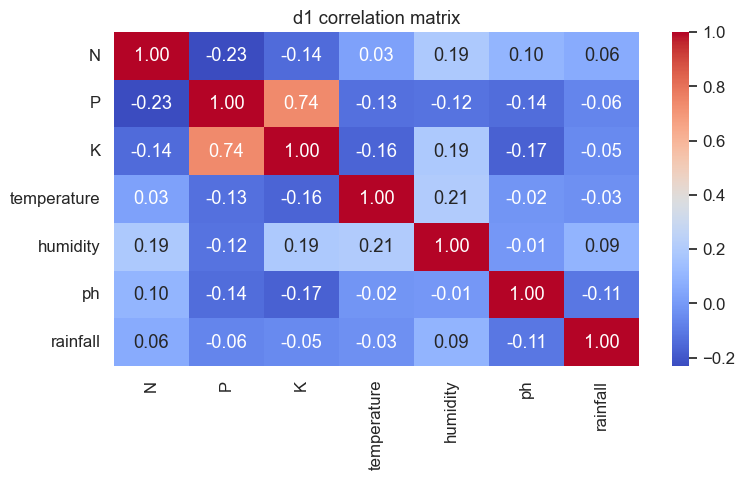

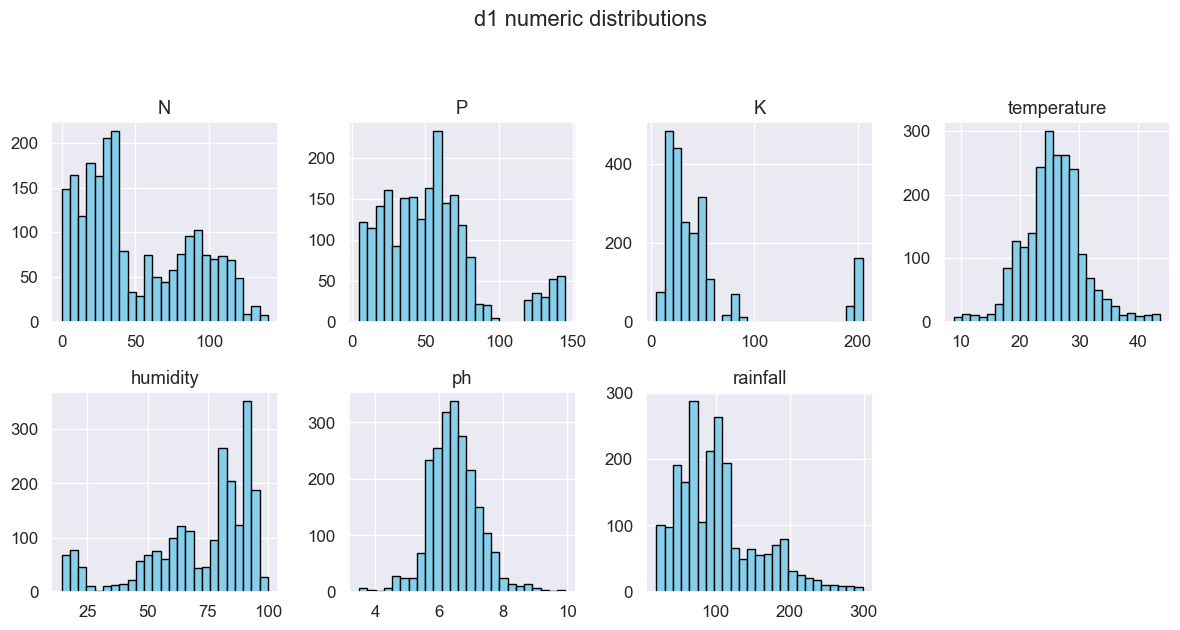

In [12]:
corr = d1_numeric.corr()
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('d1 correlation matrix')
plt.tight_layout()
plt.show()

d1_numeric.hist(bins=25, figsize=(12, 6), layout=(2, 4), color='skyblue', edgecolor='black')
plt.suptitle('d1 numeric distributions', y=1.05)
plt.tight_layout()
plt.show()

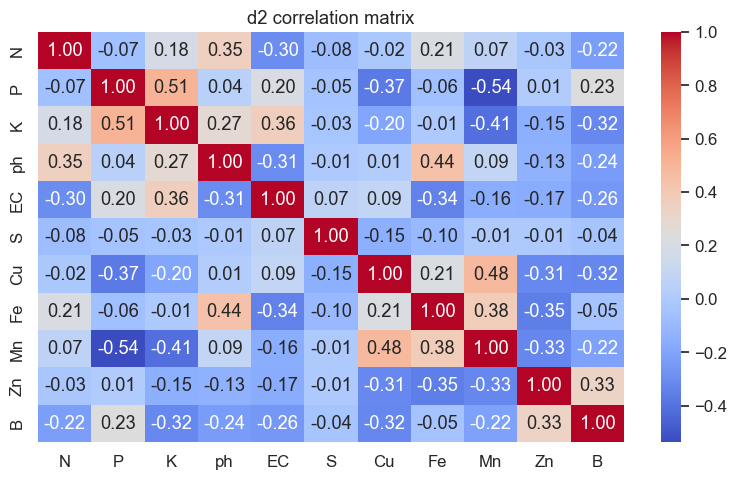

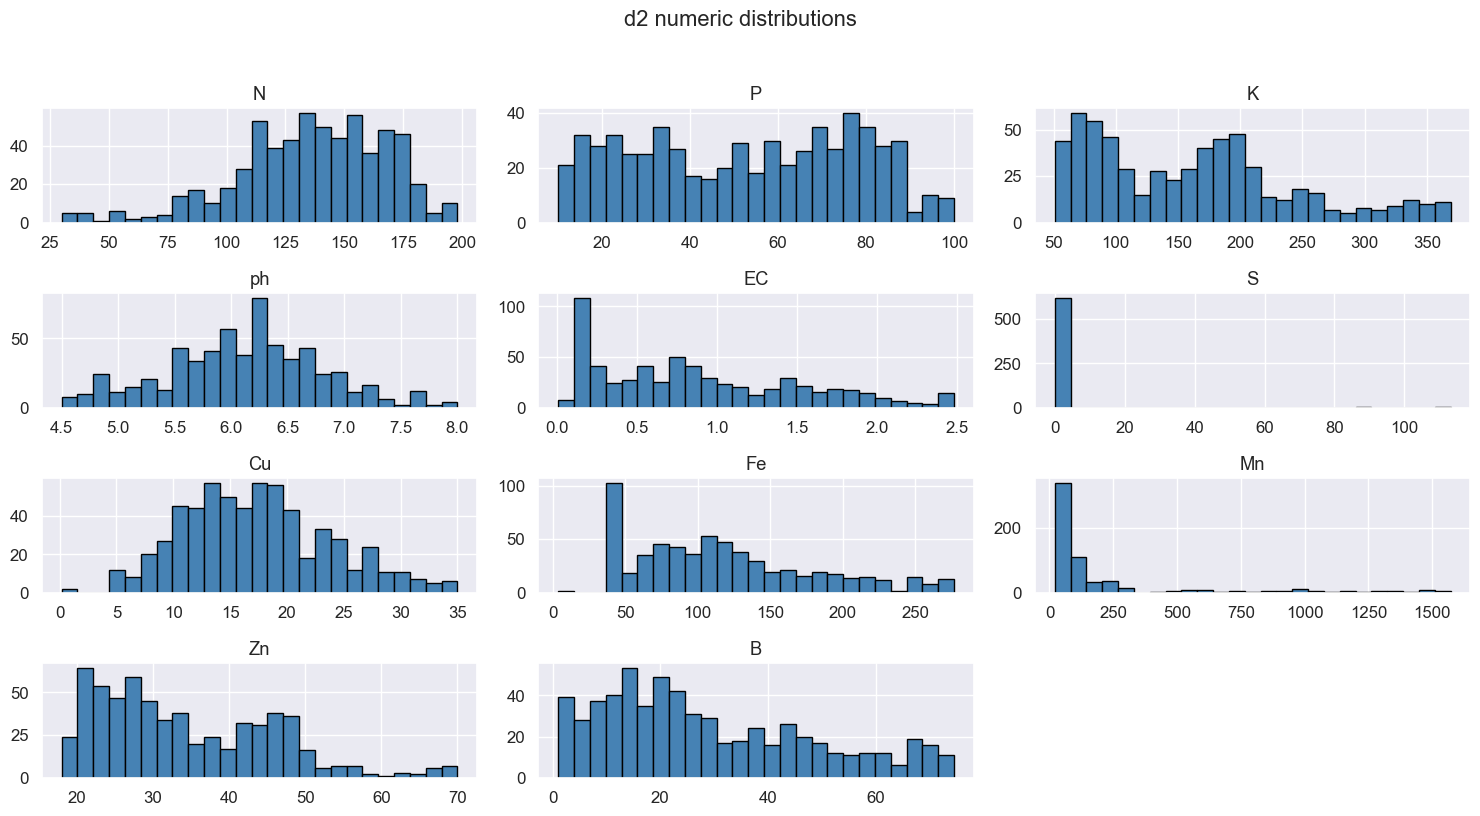

In [13]:
corr = d2_numeric.corr()
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('d2 correlation matrix')
plt.tight_layout()
plt.show()

d2_numeric.hist(bins=25, figsize=(15, 8), color='steelblue', edgecolor='black')
plt.suptitle('d2 numeric distributions', y=1.02)
plt.tight_layout()
plt.show()

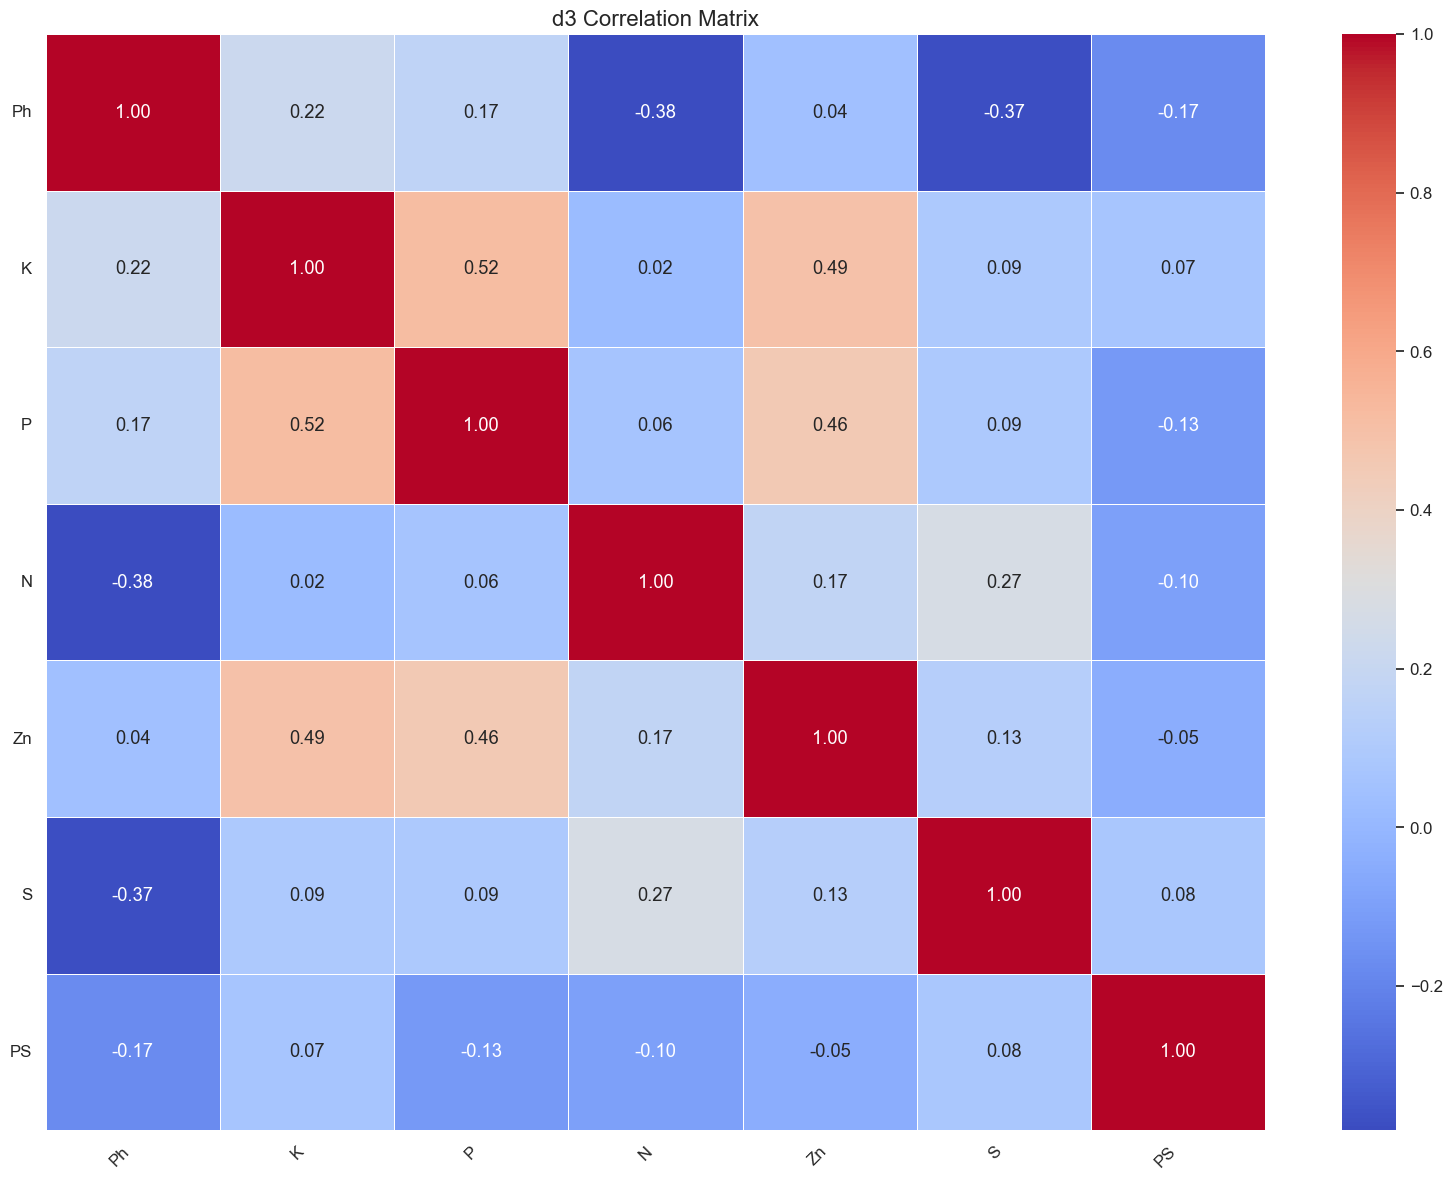

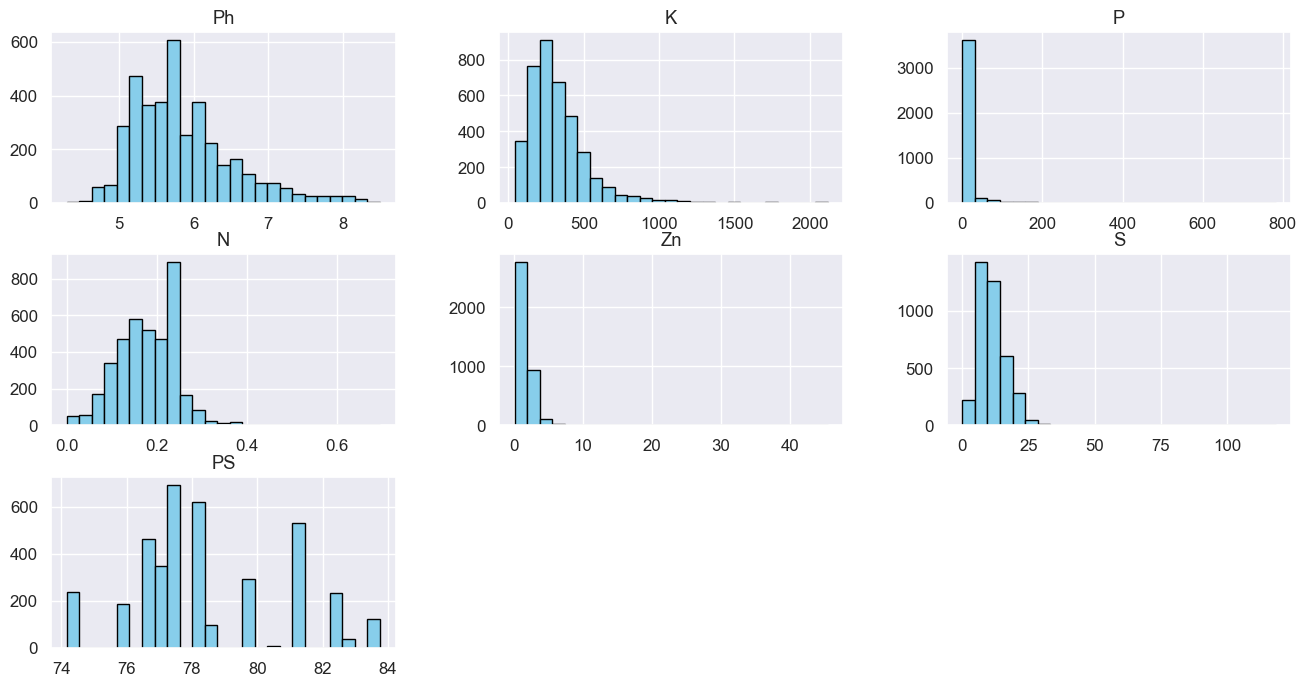

In [14]:
corr = d3_numeric.corr()
plt.figure(figsize=(16, 12))  
sns.heatmap(
    corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    linewidths=0.5, 
    cbar=True,
    square=False
)

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.title('d3 Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()


subset_cols = d3_numeric.columns[:12]  
d3_numeric[subset_cols].hist(bins=25, figsize=(16,8), color='skyblue', edgecolor='black')
plt.show()

## 3. Image model: soil-type classifier
We train a ResNet50 on the soil image dataset and keep the best checkpoint for downstream soil-type inference.

In [15]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    img_df,
    test_size=0.2,
    stratify=img_df["label"],
    random_state=42,
)
val_rel = 0.1 / 0.8  # 10% of total reserved for val
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_rel,
    stratify=train_val_df["label"],
    random_state=42,
)

class_names = sorted(img_df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
num_classes = len(class_names)

print({"train": len(train_df), "val": len(val_df), "test": len(test_df)})

{'train': 4399, 'val': 629, 'test': 1258}


In [16]:
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class SoilImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filepath"]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = class_to_idx[row["label"]]
        return image, label

train_dataset = SoilImageDataset(train_df, transform=train_transform)
val_dataset = SoilImageDataset(val_df, transform=val_test_transform)
test_dataset = SoilImageDataset(test_df, transform=val_test_transform)

NUM_WORKERS = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Device: cpu


In [17]:
from copy import deepcopy
import time
from sklearn.metrics import classification_report, confusion_matrix


def train_image_model(num_epochs=5, lr=1e-3):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_wts = deepcopy(model.state_dict())
    best_val_acc = 0.0

    if CKPT_PATH.exists():
        model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
        print("Loaded ResNet50 checkpoint from", CKPT_PATH)
        return model

    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double().item() / len(train_loader.dataset)

        model.eval()
        val_corrects = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double().item() / len(val_loader.dataset)

        elapsed = time.time() - start
        print(f"Epoch {epoch+1}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f} | {elapsed:.1f}s")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wts = deepcopy(model.state_dict())

    model.load_state_dict(best_wts)
    return model

image_model = train_image_model(num_epochs=5, lr=1e-3)


Loaded ResNet50 checkpoint from artifacts\best_resnet_soil.pth


In [17]:
# Evaluate on held-out test set
image_model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = image_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

print("Test classification report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Image model confusion matrix")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## 4. Tabular Model: Crop Recommender

In [18]:
# XGBoost classifier for tabular recommender
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def preprocess_tabular(df):
    X = df.drop(columns=["label"]).copy()
    y = df["label"].copy()

    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(y)

    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    soilcolor_categories = None
    if "Soilcolor" in X.columns:
        soilcolor_categories = sorted(X["Soilcolor"].astype(str).unique())
        cat_cols = [c for c in cat_cols if c != "Soilcolor"]

    feat_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        feat_encoders[col] = le

    if soilcolor_categories:
        soil_dummies = pd.get_dummies(X["Soilcolor"].astype(str), prefix="Soilcolor")
        X = pd.concat([X.drop(columns=["Soilcolor"]), soil_dummies], axis=1)

    medians = X.median(numeric_only=True)
    X = X.fillna(medians)
    X = X.astype(float)

    return X, y_enc, label_encoder, feat_encoders, medians, cat_cols, soilcolor_categories


=== Training XGBoost on d3 (rows=3867) ===
d3 validation accuracy: 0.450

Classification report:

              precision    recall  f1-score   support

      Barley       0.35      0.42      0.38       101
        Bean       0.14      0.10      0.11        51
     Dagussa       0.00      0.00      0.00        14
      Fallow       0.00      0.00      0.00         5
       Maize       0.51      0.62      0.56       146
  Niger seed       0.00      0.00      0.00        13
         Pea       0.29      0.26      0.28        19
      Potato       0.14      0.10      0.12        10
  Red Pepper       0.50      0.33      0.40         6
     Sorghum       0.33      0.21      0.26        14
        Teff       0.58      0.59      0.58       252
       Wheat       0.41      0.36      0.38       143

    accuracy                           0.45       774
   macro avg       0.27      0.25      0.26       774
weighted avg       0.43      0.45      0.44       774



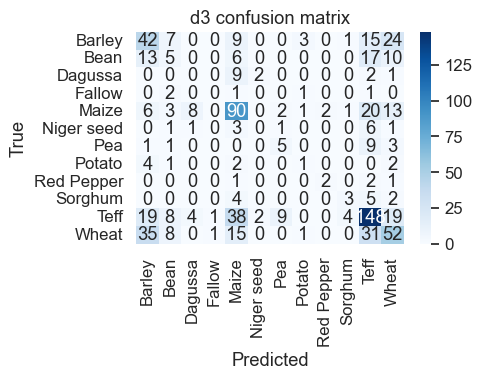


=== Training XGBoost on d1 (rows=2200) ===
d1 validation accuracy: 0.993

Classification report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       1.00      1.00      1.00        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.90      0.95        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20
    mungbean       0.95      1.00      0.98        20
   muskmelon       1.00      1.00   

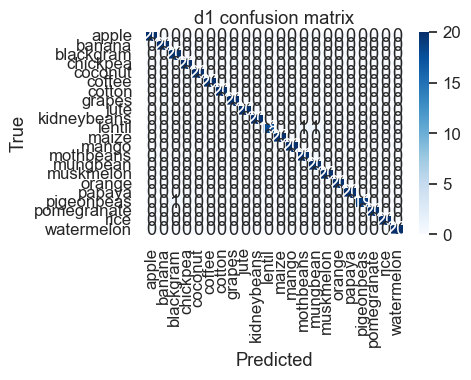


=== Training XGBoost on d2 (rows=620) ===
d2 validation accuracy: 0.960

Classification report:

              precision    recall  f1-score   support

      grapes       0.95      0.95      0.95        21
       mango       1.00      0.95      0.97        20
    mulberry       0.90      0.90      0.90        21
 pomegranate       1.00      0.95      0.98        21
      potato       1.00      1.00      1.00        20
        ragi       0.91      1.00      0.95        21

    accuracy                           0.96       124
   macro avg       0.96      0.96      0.96       124
weighted avg       0.96      0.96      0.96       124



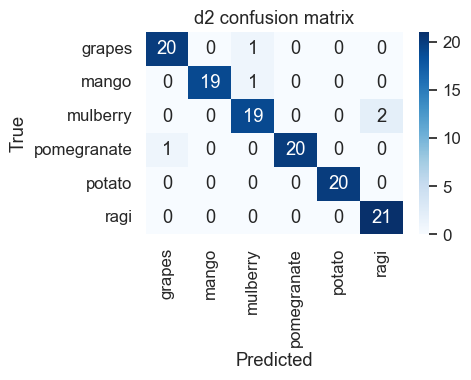

In [19]:
# Train on d3 first, then train fresh models on d1 and d2 (schemas differ, so we keep per-dataset models)
import xgboost as xgb

order = ["d3", "d1", "d2"]
xgb_models = {}

for name in order:
    df = datasets[name]
    print(f"\n=== Training XGBoost on {name} (rows={df.shape[0]}) ===")
    X, y_enc, label_encoder, feat_encoders, medians, cat_cols, soilcolor_categories = preprocess_tabular(df)

    X_train, X_val, y_train, y_val = train_test_split(
        X.values,
        y_enc,
        test_size=0.2,
        random_state=42,
        stratify=y_enc,
    )

    classes, counts = np.unique(y_enc, return_counts=True)
    class_weights = {cls: len(y_enc) / (len(classes) * count) for cls, count in zip(classes, counts)}
    train_weights = np.array([class_weights[c] for c in y_train])

    num_classes = len(label_encoder.classes_)
    clf = XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=2,
        gamma=0.1,
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric=["mlogloss", "merror"],
        tree_method="hist",
        random_state=42,
    )

    clf.fit(
        X_train,
        y_train,
        sample_weight=train_weights,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    y_pred = clf.predict_proba(X_val).argmax(axis=1)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} validation accuracy: {acc:.3f}")
    print("\nClassification report:\n")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{name} confusion matrix")
    plt.tight_layout()
    plt.show()

    meta = {
        "label_encoder": label_encoder,
        "feat_encoders": feat_encoders,
        "medians": medians,
        "cat_cols": cat_cols,
        "feature_order": X.columns.tolist(),
        "soilcolor_categories": soilcolor_categories,
    }
    xgb_models[name] = {"model": clf, "meta": meta}

# keep backward-compatible reference for pipeline
tabnet_models = xgb_models

## 4. Complete pipline
Infer soil type from an image, map it to tabular features, and predict the crop using the chosen TabNet model (default: `d3` because it contains soil color information).

In [22]:
import torch.nn.functional as F

# Map image model classes to d3 Soilcolor values (adjust as needed)
# Ensure these values match the output of clean_soil_color
image_to_soilcolor = {
    "Black_Soil": "black",
    "Red_Soil": "red",
    "Yellow_Soil": "yellowish brown",
    "Alluvial_Soil": "brown",
    "Arid_Soil": "brown",
    "Laterite_Soil": "red",
    "Mountain_Soil": "other",
}


def predict_soil_type(image_path):
    image_model.eval()
    image = Image.open(image_path).convert("RGB")
    tensor = val_test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = image_model(tensor)
        probs = F.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        pred_conf = probs.max().item()
    return idx_to_class[pred_idx], pred_conf


def encode_categorical(value, encoder):
    value = str(value)
    classes = list(encoder.classes_)
    if value in classes:
        return encoder.transform([value])[0]
    return encoder.transform([classes[0]])[0]


def prepare_tabular_input(features, dataset_name="d3"):
    meta = tabnet_models[dataset_name]["meta"]
    feature_order = meta["feature_order"]
    cat_cols = set(meta["cat_cols"])
    feat_encoders = meta["feat_encoders"]
    medians = meta["medians"]
    soilcolor_categories = meta.get("soilcolor_categories") or []

    row = {}
    for col in feature_order:
        if col.startswith("Soilcolor_") or col == "Soilcolor":
            continue
        if col in features:
            row[col] = features[col]
        else:
            row[col] = medians[col] if col in medians else 0

    row_df = pd.DataFrame([row])

    for col in cat_cols:
        row_df[col] = row_df[col].astype(str).apply(lambda v: encode_categorical(v, feat_encoders[col]))

    if soilcolor_categories:
        soil_value = str(features.get("Soilcolor", soilcolor_categories[0]))
        for cat in soilcolor_categories:
            col_name = f"Soilcolor_{cat}"
            row_df[col_name] = 1 if soil_value == cat else 0

    for col in feature_order:
        if col not in row_df.columns:
            default_val = medians[col] if col in medians else 0
            row_df[col] = default_val

    row_df = row_df[feature_order]
    row_df = row_df.fillna(medians)
    row_df = row_df.astype(float)
    return row_df.values


def recommend_crop(image_path, tabular_features, dataset_name="d3"):
    soil_label, soil_conf = predict_soil_type(image_path)

    # inject predicted soil color/type when available
    if dataset_name == "d3" and "Soilcolor" in datasets["d3"].columns and "Soilcolor" not in tabular_features:
        mapped = image_to_soilcolor.get(soil_label, datasets["d3"]["Soilcolor"].mode().iloc[0])
        tabular_features = {**tabular_features, "Soilcolor": mapped}

    sample_x = prepare_tabular_input(tabular_features, dataset_name)
    model = tabnet_models[dataset_name]["model"]
    label_encoder = tabnet_models[dataset_name]["meta"]["label_encoder"]

    proba = model.predict_proba(sample_x)
    pred_idx = proba.argmax(axis=1)[0]
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    return {
        "soil_prediction": soil_label,
        "soil_confidence": soil_conf,
        "crop_recommendation": pred_label,
        "tabular_dataset_used": dataset_name,
    }

# Example usage (update feature values before running):
# example_features = {k: v for k, v in datasets['d3'].drop(columns=['label']).median(numeric_only=True).items()}
# result = recommend_crop('./data/soil_images/Orignal-Dataset/Black_Soil/some_image.jpg', example_features, dataset_name='d3')
# print(result)

## 5. Final testing 

In [23]:
# Update these paths/values before running
example_image_path = "./data/soil_images/Orignal-Dataset/Black_Soil/1.jpg"  # replace with an existing file

# Use medians from chosen dataset as a quick placeholder
base_features = datasets['d3'].drop(columns=['label']).median(numeric_only=True).to_dict()
result = recommend_crop(example_image_path, base_features, dataset_name='d3')
print(result)


{'soil_prediction': 'Black_Soil', 'soil_confidence': 0.9998378753662109, 'crop_recommendation': 'Barley', 'tabular_dataset_used': 'd3'}
